Name: Vijaykumar Maraviya

Student Number: 1006040320

In [1]:
import gym
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from sklearn.preprocessing import KBinsDiscretizer
from itertools import product
import collections

### Mountain Car environment and discretization of state space

In [2]:
mc_env = gym.make('MountainCar-v0')
mc_env.reset()

# lower bounds of state space
lower_bounds = mc_env.observation_space.low

# upper bounds of state space
upper_bounds = mc_env.observation_space.high

n_bins = (12, 12)

# discretize the state
def mc_discretizer(car_position, car_velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int, est.transform([[car_position, car_velocity]])[0]))

# action_space
mc_action_space = [0,1,2]

# discretized state_space
mc_state_space = []
for s in product(range(12), range(12)):
    mc_state_space.append(s)

### performance test

In [10]:
def test(Q, eps, num_episodes = 1000):
    rewards = np.zeros(num_episodes)
    for i in range(num_episodes):
        totalReward = 0
        observation = mc_discretizer(*mc_env.reset())
        done = False
        while not done:
            action =  e_greedy(Q, eps, observation)
            observation_, reward, done, info = mc_env.step(action)            
            observation = mc_discretizer(*observation_)
            totalReward += reward
        rewards[i] = totalReward
    
    print(f"Average reward over {num_episodes} episodes: {np.average(rewards):.2f}")
    print(f"number of successes (reward >= -199) in {num_episodes} episodes: {np.sum(np.where(rewards >= -199, 1, 0))}")
    
    plt.figure(2, figsize=[10,5])
    plt.plot(rewards)
    plt.xlabel('episode number')
    plt.ylabel('reward')
    plt.show()

## Implementation

This function selects an action using e-greedy policy for a given Q

In [4]:
def e_greedy(Q, eps, S):
    # random action with probability eps
    if np.random.random() < eps:
        return np.random.choice([0,1,2])
    
    # greedy action otherwise
    act_vals = np.array([Q[(S,a)] for a in [0,1,2]])
    return np.random.choice(np.where(act_vals == act_vals.max())[0])

In [5]:
def decay_eps(current_eps, eps_min, eps_dec):
    new_eps = current_eps - eps_dec
    return max(new_eps, eps_min)

### a. on-policy SARSA

In [6]:
def on_policy_SARSA(env, state_space, action_space, descritizer,
                    max_episodes = 50000, GAMMA = 1.0,
                    EPS_MAX = 1.0, EPS_MIN = 0.05,
                    ALPHA = 0.1):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
        
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0
    
    scores = []
    
    # loop for max_episodes
    for episode in range(max_episodes):
        
        # initialize S
        obs = env.reset()
        S = descritizer(*obs)
        
        # choose A
        A = e_greedy(Q, eps, S)
        
        score = 0
        done = False
        
        while not done:            
            # take action A, observe R and S_next
            obs, R, done, _ = env.step(A)
            S_next = descritizer(*obs)
            
            score += R
            
            # choose A_next
            A_next = e_greedy(Q, eps, S_next)
            
            # updtae Q
            Q[(S,A)] = Q[(S,A)] + ALPHA*(R + GAMMA*Q[(S_next, A_next)] - Q[(S,A)])
            
            # next S, A
            S, A = S_next, A_next
        
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])

        if episode % 1000 == 0:
            print('episode:', episode, '| avg_reward for last 1000 episodes: %.1f' % avg_score)
        
    return Q, scores

In [7]:
# on-policy SARSA
Q_on_policy_sarsa, rewards_on_policy_sarsa = on_policy_SARSA(env = mc_env,
                                                                    state_space = mc_state_space,
                                                                    action_space = mc_action_space,
                                                                    descritizer = mc_discretizer, 
                                                                    max_episodes = 20000)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -198.8
episode: 7000 | avg_reward for last 1000 episodes: -193.4
episode: 8000 | avg_reward for last 1000 episodes: -185.2
episode: 9000 | avg_reward for last 1000 episodes: -173.4
episode: 10000 | avg_reward for last 1000 episodes: -154.4
episode: 11000 | avg_reward for last 1000 episodes: -171.8
episode: 12000 | avg_reward for last 1000 episodes: -150.2
episode: 13000 | avg_reward for last 1000 episodes: -166.0
episode: 14000 | avg_reward for last 1000 episodes: -158.0
episode: 15000 | avg_reward for last 1000 episodes: -171.2
episode: 16000 | avg_reward for last 1000 episodes: -175.9
episode: 1

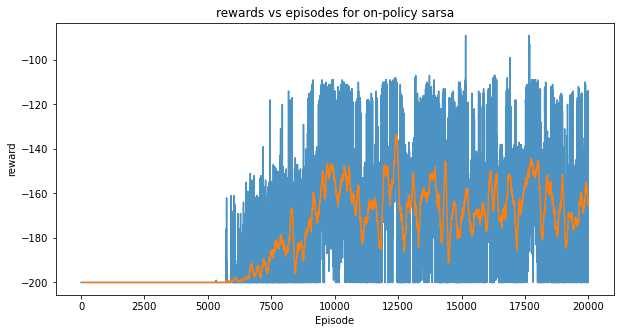

In [8]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_on_policy_sarsa)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for on-policy sarsa')
plt.show()

Average reward over 100 episodes: -147.19
number of successes (reward >= -199) in 100 episodes: 100


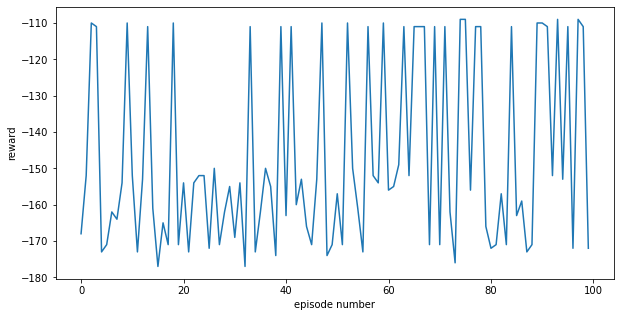

In [11]:
# test the learned policy
test(Q_on_policy_sarsa, 0, 100)